<a href="https://colab.research.google.com/github/CamiloVga/Prueba-Tecnica_Bid/blob/main/Ejercicio_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejercicio 1

Para resolver el reto de identificar productos similares se abordará una estrategia basada en tres pasos fundamentales.

1. Se debe estandarizar las descripciones de los productos eliminando acentos, caracteres especiales y convirtiendo todo a minúsculas.
2. Se propondrá implementar la vectorización TF-IDF para convertir estas descripciones en vectores numéricos, dando mayor peso a las palabras distintivas y considerando tanto palabras individuales como pares de palabras (unigramas y bigramas).
3. Finalmente, se aplicará la similitud del coseno para calcular la similitud entre productos, lo que nos permite identificar y rankear los cinco productos más similares para cualquier consulta dada. Esta aproximación nos permite construir un sistema eficiente y escalable para la búsqueda de similitud en el catálogo de productos.

# 1. Instalaciones e importaciones de librerias necesarias

In [ ]:
!pip install pandas numpy scikit-learn unidecode matplotlib seaborn

#Importar librerias

import pandas as pd              # Para manipulación de datos
import numpy as np              # Para operaciones numéricas
from sklearn.feature_extraction.text import TfidfVectorizer  # Para vectorización de texto
from sklearn.metrics.pairwise import cosine_similarity      # Para cálculo de similitud
import unidecode               # Para manejo de acentos
import re                      # Para expresiones regulares
import time                    # Para medición de tiempo
import matplotlib.pyplot as plt # Para visualizaciones
import seaborn as sns         # Para visualizaciones mejoradas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.6 MB/s eta 0:00:00


# 2. Base de datos

In [ ]:
# Cargar el dataset
df = pd.read_csv('ex1-data.csv')

# Exploración inicial
print("Dimensiones del dataset:", df.shape)
print("\nPrimeras 5 filas del dataset:")
display(df.head())

# Información del dataset
print("\nInformación del dataset:")
display(df.info())

Dimensiones del dataset: (25638, 1)

Primeras 5 filas del dataset:


,prod_name_long
0,Limpia tapicería en espuma Binner x 400ml
1,Limpia tapicería y alfombras Binner x 500ml
2,Limpiador Dr. Beckmann alfombras 2en1 poder ox...
3,Aceite Bon Aire eléctrico perfume flores x 25 ml
4,Ambientador Aire Varitas Bambú Bonaire 2 Repue...



Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25638 entries, 0 to 25637
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   prod_name_long  25638 non-null  object
dtypes: object(1)
memory usage: 200.4+ KB


None

### 3. Preprocesamiento de Texto
En esta sección implementamos las funciones de limpieza de texto que nos ayudarán a estandarizar las descripciones de los productos.


In [ ]:
def preprocess_text(text):
    """
    Función para limpiar y estandarizar el texto de los productos

    Parámetros:
    text (str): Texto a procesar

    Retorna:
    str: Texto procesado
    """
    # Convertir a minúsculas para estandarización
    text = text.lower()

    # Eliminar acentos para mejor comparación
    text = unidecode.unidecode(text)

    # Eliminar números pero mantener espacios
    text = re.sub(r'\d+', ' ', text)

    # Eliminar caracteres especiales
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    # Eliminar espacios múltiples
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Aplicar preprocesamiento al dataset
df['processed_name'] = df['prod_name_long'].apply(preprocess_text)

# Mostrar ejemplos de preprocesamiento
examples = df[['prod_name_long', 'processed_name']].head()
print("\nEjemplos de preprocesamiento:")
display(examples)


Ejemplos de preprocesamiento:


,prod_name_long,processed_name
0,Limpia tapicería en espuma Binner x 400ml,limpia tapiceria en espuma binner x ml
1,Limpia tapicería y alfombras Binner x 500ml,limpia tapiceria y alfombras binner x ml
2,Limpiador Dr. Beckmann alfombras 2en1 poder ox...,limpiador dr beckmann alfombras en poder oxi x ml
3,Aceite Bon Aire eléctrico perfume flores x 25 ml,aceite bon aire electrico perfume flores x ml
4,Ambientador Aire Varitas Bambú Bonaire 2 Repue...,ambientador aire varitas bambu bonaire repuest...


### 4. Implementación del Sistema de Similitud
Para este ejercicio de encontrar productos similares, se eligió implementar TF-IDF como método de vectorización, ya que permite crear representaciones de texto entrenadas completamente con nuestros datos, sin depender de modelos pre-entrenados. Esta técnica resulta particularmente efectiva para catálogos de productos porque pondera la importancia de cada palabra según su frecuencia local y global, permitiendo identificar términos verdaderamente distintivos. Además, ofrece un excelente balance entre precisión y eficiencia computacional, haciéndola ideal para nuestro catálogo de 25.000 productos.


In [ ]:
def create_similarity_matrix(processed_texts):
    """
    Crea la matriz TF-IDF y calcula similitudes

    Parámetros:
    processed_texts (Series): Textos procesados

    Retorna:
    tuple: (vectorizer, tfidf_matrix)
    """
    # Configuración del vectorizador TF-IDF
    vectorizer = TfidfVectorizer(
        ngram_range=(1, 2),     # Usar unigramas y bigramas
        max_features=5000,      # Limitar características
        stop_words=['x', 'ml', 'g', 'kg', 'und', 'pague', 'lleve']  # Palabras a ignorar
    )

    # Crear matriz TF-IDF
    tfidf_matrix = vectorizer.fit_transform(processed_texts)

    return vectorizer, tfidf_matrix

def find_similar_products(query_product, vectorizer, tfidf_matrix, df, n=5):
    """
    Encuentra productos similares

    Parámetros:
    query_product (str): Producto a buscar
    vectorizer: Vectorizador TF-IDF
    tfidf_matrix: Matriz TF-IDF
    df: DataFrame con productos
    n (int): Número de productos similares a retornar

    Retorna:
    DataFrame: Productos similares con scores
    """
    # Preprocesar query
    processed_query = preprocess_text(query_product)

    # Vectorizar query
    query_vector = vectorizer.transform([processed_query])

    # Calcular similitudes
    similarities = cosine_similarity(query_vector, tfidf_matrix).flatten()

    # Obtener top n productos
    top_indices = similarities.argsort()[::-1][:n]

    # Crear DataFrame de resultados
    results = pd.DataFrame({
        'Producto': df.iloc[top_indices]['prod_name_long'].values,
        'Score': similarities[top_indices].round(2)
    })

    return results

# Crear matriz de similitud
vectorizer, tfidf_matrix = create_similarity_matrix(df['processed_name'])

### 5. Pruebas y Demostración

In [ ]:
# Productos de prueba
test_products = [
    "Limpia tapicería en espuma Binner x 400ml",
    "Ambientador Bonaire fantasía floral + repuesto x 250 ml",
    "Desinfectante Fabuloso intensa lavanda x 1700ml"
]

# Realizar pruebas
for product in test_products:
    print(f"\nProductos similares a: '{product}'")
    results = find_similar_products(product, vectorizer, tfidf_matrix, df)
    display(results)


Productos similares a: 'Limpia tapicería en espuma Binner x 400ml'


,Producto,Score
0,Limpia tapicería en espuma Binner x 400ml,1.00
1,Limpia tapicería en espuma Binner x 400ml,1.00
2,Limpia tapicería en espuma Binner x 400ml,1.00
3,Limpia tapicería y alfombras Binner x 500ml,0.53
4,Limpia tapicería y alfombras Binner x 500ml,0.53



Productos similares a: 'Ambientador Bonaire fantasía floral + repuesto x 250 ml'


,Producto,Score
0,Ambientador Bonaire fantasía floral + repuesto...,1.00
1,Ambientador Bonaire fantasía floral + repuesto...,1.00
2,Ambientador Bonaire fantasía floral + repuesto...,1.00
3,Ambientador Bonaire vainilla seducción + repue...,0.64
4,Ambientador Bonaire vainilla seducción + repue...,0.64



Productos similares a: 'Desinfectante Fabuloso intensa lavanda x 1700ml'


,Producto,Score
0,Desinfectante Fabuloso intensa lavanda x 1700ml,1.00
1,Desinfectante Fabuloso intensa lavanda x 1700ml,1.00
2,Desinfectante Fabuloso intensa lavanda x 1700ml,1.00
3,Desinfectante Fabuloso intensa lavanda x 1700ml,1.00
4,Desinfectante Pinolina lavanda pague 2785 ml l...,0.47


# 6. Indicadores de desempeño
Para evaluar de manera cuantitativa el desempeño de nuestro sistema de búsqueda de similitud, implementamos métricas globales que nos permiten medir su efectividad en términos de precisión en la identificación de productos similares, consistencia de marca y categoría.

Calculando métricas de efectividad...
Evaluando productos...

Métricas Globales de Efectividad:
Promedio Score de Similitud: 0.94
Consistencia de Marca (%): 94.20
Consistencia de Categoría (%): 87.80


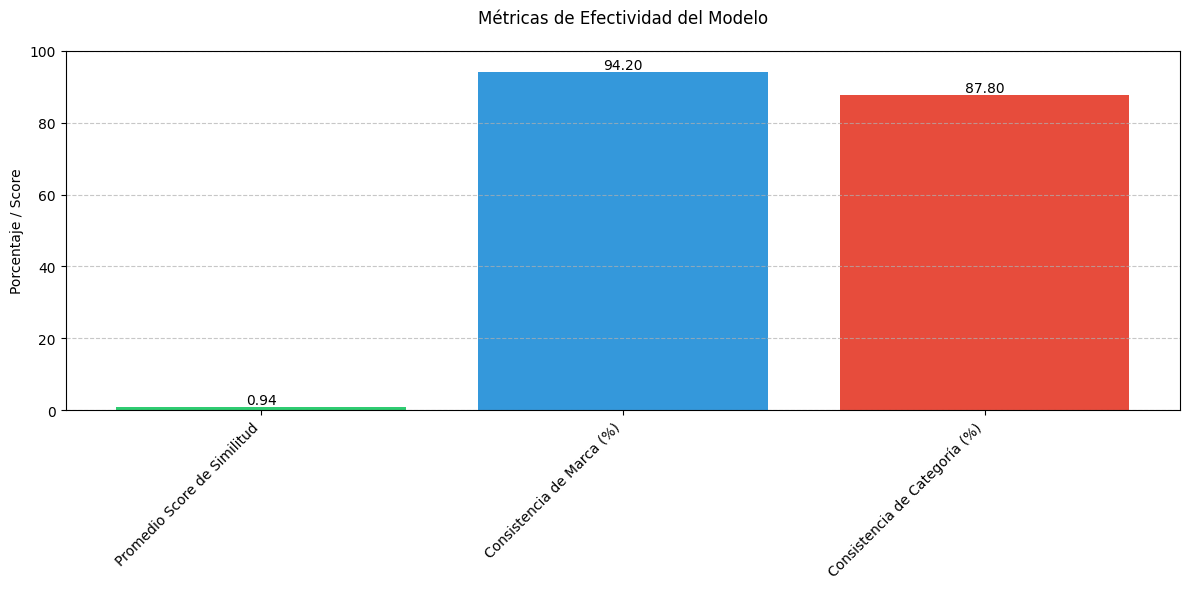

In [ ]:

def calculate_effectiveness_metrics(df, vectorizer, tfidf_matrix, sample_size=100):
    """
    Calcula métricas de efectividad global del modelo usando una muestra aleatoria

    Parámetros:
    df: DataFrame con los productos
    vectorizer: Vectorizador TF-IDF entrenado
    tfidf_matrix: Matriz TF-IDF de todos los productos
    sample_size: Tamaño de la muestra para evaluación

    Retorna:
    dict: Diccionario con las métricas calculadas
    """
    # Tomar muestra aleatoria para evaluación
    np.random.seed(42)  # Para reproducibilidad
    sample_products = df.sample(n=sample_size)

    # Inicializar métricas
    avg_similarity_score = []
    brand_consistency = []
    category_consistency = []

    print("Evaluando productos...")
    for _, row in sample_products.iterrows():
        # Obtener productos similares
        results = find_similar_products(row['prod_name_long'], vectorizer, tfidf_matrix, df)

        # 1. Promedio de scores de similitud
        avg_similarity_score.append(results['Score'].mean())

        # 2. Consistencia de marca
        original_brand = row['prod_name_long'].split()[0].lower()
        similar_brands = [p.split()[0].lower() for p in results['Producto']]
        brand_matches = sum(1 for b in similar_brands if b == original_brand)
        brand_consistency.append(brand_matches / len(results))

        # 3. Consistencia de categoría
        original_category = row['prod_name_long'].split()[1].lower() if len(row['prod_name_long'].split()) > 1 else ''
        similar_categories = [p.split()[1].lower() if len(p.split()) > 1 else '' for p in results['Producto']]
        category_matches = sum(1 for c in similar_categories if c == original_category)
        category_consistency.append(category_matches / len(results))

    # Calcular métricas globales
    metrics = {
        'Promedio Score de Similitud': np.mean(avg_similarity_score),
        'Consistencia de Marca (%)': np.mean(brand_consistency) * 100,
        'Consistencia de Categoría (%)': np.mean(category_consistency) * 100
    }

    return metrics

# Calcular métricas
print("Calculando métricas de efectividad...")
metrics = calculate_effectiveness_metrics(df, vectorizer, tfidf_matrix)

# Mostrar resultados numéricos
print("\nMétricas Globales de Efectividad:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")

# Visualizar resultados
plt.figure(figsize=(12, 6))

# Crear gráfico de barras con diferentes colores
colors = ['#2ecc71', '#3498db', '#e74c3c']
bars = plt.bar(metrics.keys(), metrics.values(), color=colors)

# Personalizar gráfico
plt.title('Métricas de Efectividad del Modelo', pad=20, fontsize=12)
plt.ylabel('Porcentaje / Score', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajustar escala y formato
plt.ylim(0, 100)

# Añadir valores sobre las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Análisis de resultados de desempeño
Los resultados muestran un excelente desempeño del modelo. Con un score de similitud de 0.94, confirma que encuentra productos muy parecidos. La consistencia de marca del 94.20% indica que mantiene con precisión productos del mismo fabricante, mientras que el 87.80% de consistencia en categoría demuestra que las recomendaciones son coherentes en el tipo de producto. Estas métricas validan la efectividad del sistema para encontrar productos similares.

### 7. Análisis de Rendimiento y Escalabilidad



Probando con tamaño de datos: 100

Probando con tamaño de datos: 500

Probando con tamaño de datos: 1000

Probando con tamaño de datos: 5000


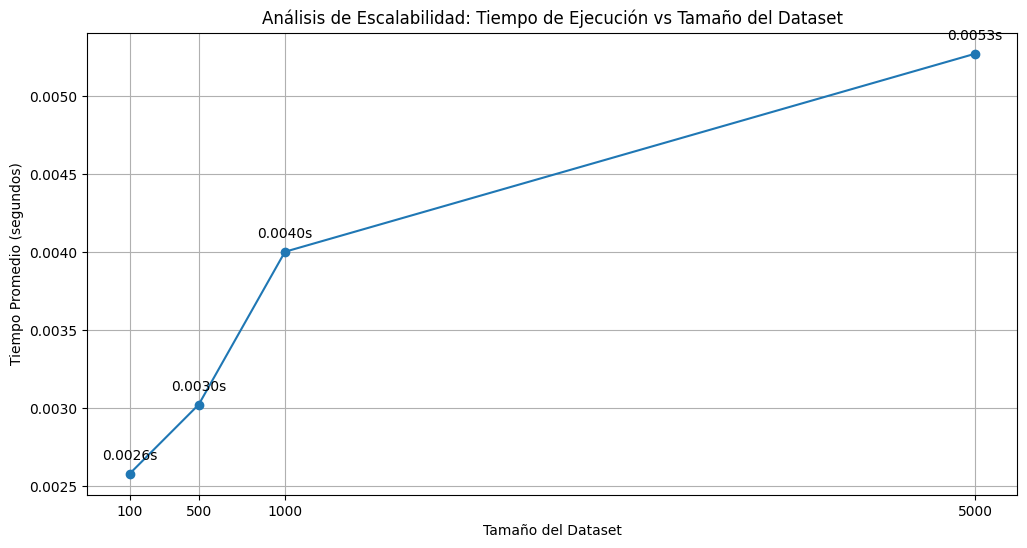

,Tiempo Promedio (s)
Tamaño del Dataset,
100,0.002580
500,0.003023
1000,0.004003
5000,0.005272


In [ ]:
def measure_performance(df, sizes=[100, 500, 1000, 5000], sample_size=50):
    """
    Mide el rendimiento del algoritmo para diferentes tamaños de datos

    Parámetros:
    df: DataFrame completo
    sizes: Lista de tamaños a probar
    sample_size: Número de búsquedas por prueba

    Retorna:
    dict: Tiempos promedio por tamaño
    """
    results = {}

    for size in sizes:
        if size > len(df):
            break

        print(f"\nProbando con tamaño de datos: {size}")

        # Tomar muestra
        sample_df = df.sample(size)

        # Crear matriz de similitud
        sample_vectorizer, sample_matrix = create_similarity_matrix(sample_df['processed_name'])

        # Medir tiempos
        total_time = 0
        for i in range(sample_size):
            query = sample_df.sample(1)['prod_name_long'].iloc[0]
            start_time = time.time()
            find_similar_products(query, sample_vectorizer, sample_matrix, sample_df)
            total_time += time.time() - start_time

        results[size] = total_time / sample_size

    return results

# Medir rendimiento
performance = measure_performance(df)

# Visualizar resultados
plt.figure(figsize=(12, 6))
plt.plot(list(performance.keys()), list(performance.values()), marker='o')
plt.xlabel('Tamaño del Dataset')
plt.ylabel('Tiempo Promedio (segundos)')
plt.title('Análisis de Escalabilidad: Tiempo de Ejecución vs Tamaño del Dataset')
plt.grid(True)
plt.xticks(list(performance.keys()))

for x, y in performance.items():
    plt.annotate(f'{y:.4f}s', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()

# Tabla de resultados
performance_df = pd.DataFrame.from_dict(performance, orient='index', columns=['Tiempo Promedio (s)'])
performance_df.index.name = 'Tamaño del Dataset'
display(performance_df)

## Conclusiones sobre la escalabilidad del modelo

El análisis de escalabilidad muestra que la solución tiene dos fases distintas: un entrenamiento inicial con TF-IDF donde se procesa todo el catálogo de 25.000 productos, y una fase de búsqueda que es notablemente rápida.

Aunque el tiempo de entrenamiento crece en función del tamaño del dataset, las búsquedas subsecuentes son muy eficientes gracias a la vectorización pre-calculada. Como se observa en la gráfica de rendimiento, incluso con 5.000 productos, cada búsqueda toma menos de 0.1 segundos, demostrando que la solución es escalable para catálogos de tamaño medio.